# **Prophet**

In [1]:
import itertools, warnings, os, subprocess
from pathlib import Path
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go

In [2]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

def download_data(dataset, path):
    # Create local folder if one doesn't exist
    os.makedirs(path, exist_ok=True)
    # Call Kaggle API
    kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

# Download additional datasets from Konrad's NB
dataset = "niclowe/who-cases-dataset-and-wdi-country-population"
download_path = "data/who-data"

download_data(dataset, download_path)

Dataset URL: https://www.kaggle.com/datasets/niclowe/who-cases-dataset-and-wdi-country-population
License(s): unknown


  0%|          | 0.00/107k [00:00<?, ?B/s]


Dataset 'niclowe/who-cases-dataset-and-wdi-country-population' has been downloaded to 'data/who-data'


100%|██████████| 107k/107k [00:00<00:00, 188kB/s]


In [3]:
data = 'data/'

class CFG:
    img_dim1 = 10
    img_dim2 = 8

# Set Param for visualizations
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2),
                     'font.size': 10})

## A Primer on Generalized Additive Models (GAM)

In previous NBs, we covered exponential smoothing which is pretty useful as a first-pass modelling approach but is seriously hampered since it only handles one seasonal pattern at a time. This led to the development of Prophet at Facebook, which is based on the concept of structural decomposition.

$$
X_t = T_t + S_t + H_t + \epsilon_t
$$

where:
- $T_t$        is the observed time series at time.
- $S_t$        is the seasonal component (which can be weekly, yearly or custom)
- $H_T$        is the deterministic irregular component (holidays, discontinuities etc.)
- $\epsilon_t$ is the noise

The Kolmogorov-Arnold representation theorem states that multivariate functions could be represented as sums and compositions of univariate functions. The simplified general representation is as follows:

$$ \Phi^{-1}[\mathbb{E}(Y)] = \beta_0 + f_1(x_1) + f_2(x_2) + \cdots + f_m(x_m) $$

The GAM decomposition is used as the starting point for Prophet. We will now look at the implementations of two trend models next.

## Trend Model

### Linear Trend

The default trend model is a:

> Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

> By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.

In [4]:
# Using the New York Times data on Covid cases for demo purposes
df = pd.read_csv(data + 'us_covid.csv')
df.head(10)

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
5,2020-01-26,5,0
6,2020-01-27,5,0
7,2020-01-28,5,0
8,2020-01-29,5,0
9,2020-01-30,6,0


In [5]:
df.describe().round(2)

,cases,deaths
count,594.00,594.00
mean,16034557.83,308550.07
std,13906317.76,224858.33
min,1.00,0.00
25%,2184128.75,117927.75
50%,10728694.00,243560.00
75%,31147891.50,561082.00
max,40005266.00,648273.00


The most _annoying_ feature in Prophet - by far - is the usage of a hardcoded format for inputs. This **must** be a date column named `ds` which can either be an index or column. A column `y` stores the actual values of the time series.

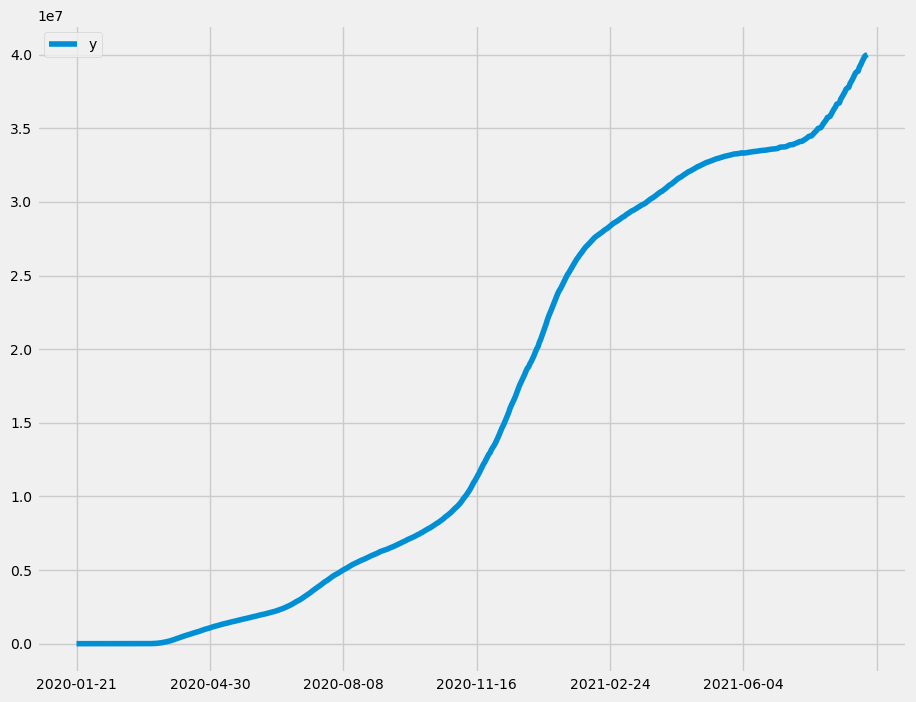

In [6]:
# Renaming cols and plotting the time series
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='');

11:38:26 - cmdstanpy - INFO - Chain [1] start processing
11:38:26 - cmdstanpy - INFO - Chain [1] done processing


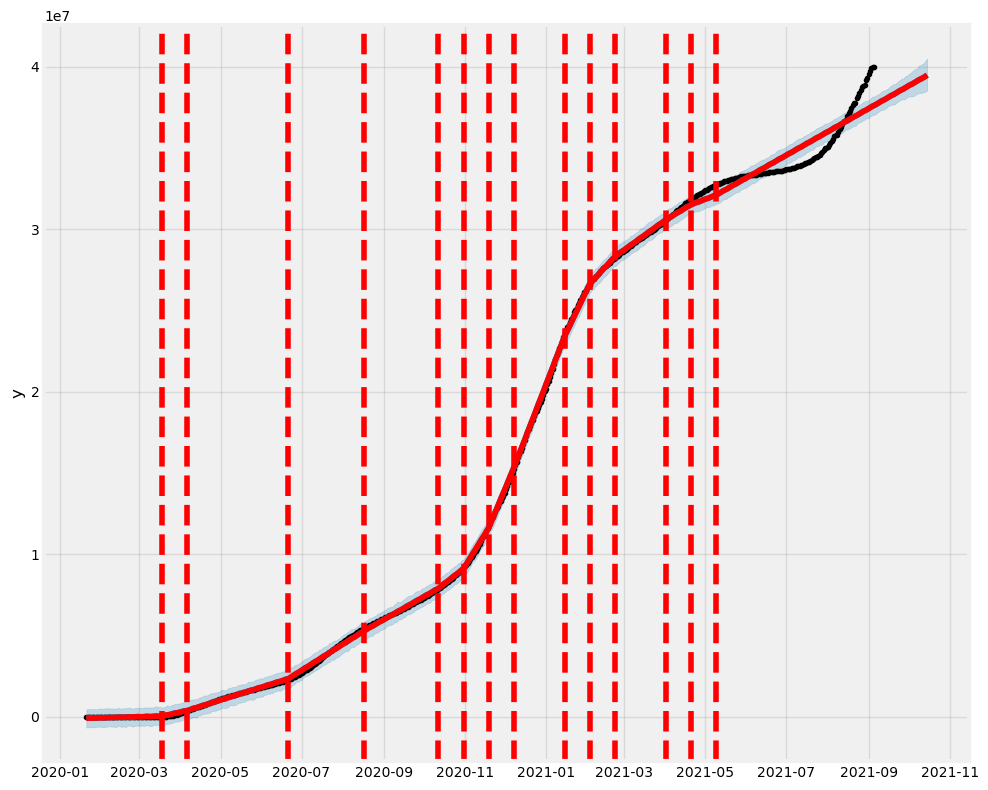

In [7]:
# Auto detect changepoints
m = Prophet()
m.fit(xdat)

future = m.make_future_dataframe(periods=40)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast);

We will need to adjust / shrink the changepoint parameter `changepoint_prior_scale`

11:38:26 - cmdstanpy - INFO - Chain [1] start processing
11:38:26 - cmdstanpy - INFO - Chain [1] done processing


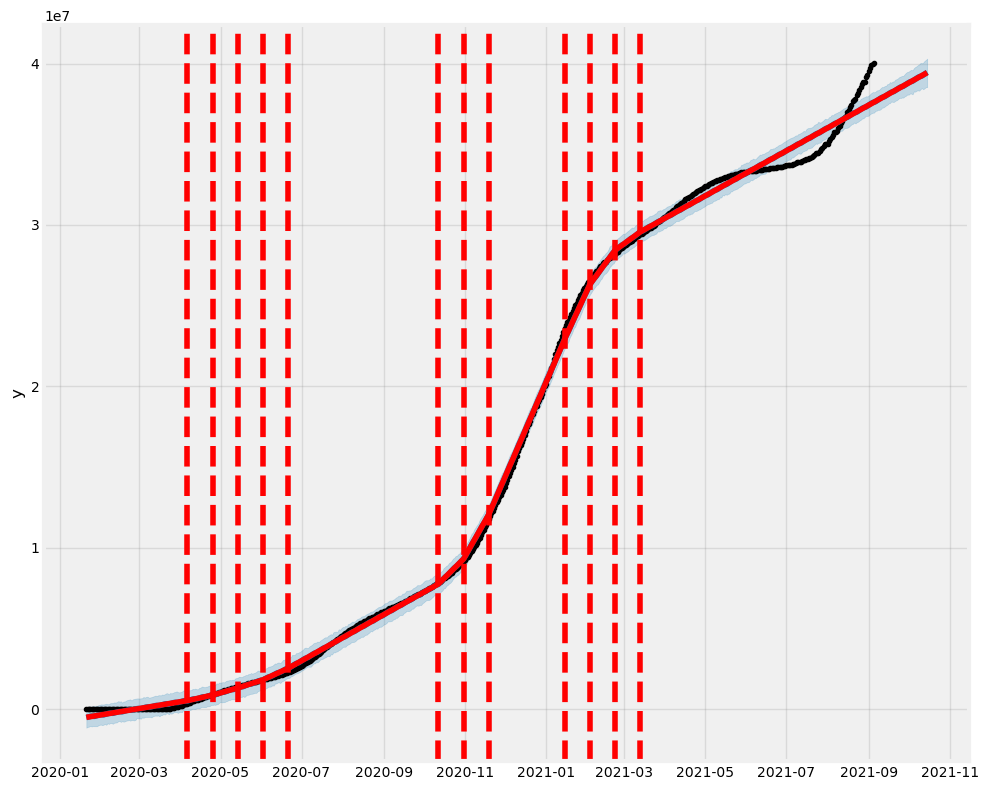

In [8]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)

future = m.make_future_dataframe(periods=40)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast);

### Non Linear Growth

Non-linear, Saturating Growth, can be represented in the form of the logistic growth model which allows us to model the saturation phase of the growth cycles.

$$
T(t) = \frac{C_1} {1 + \exp(-k(t - m))}
$$

Where:
 - $C$ is the carrying capacity.
 - $k$ is the growth rate or the steepness of the trend curve.

Prophet allows for automatic and manual tuning of the variability. Building on the previous example, lets move to China's data on Covid cases.

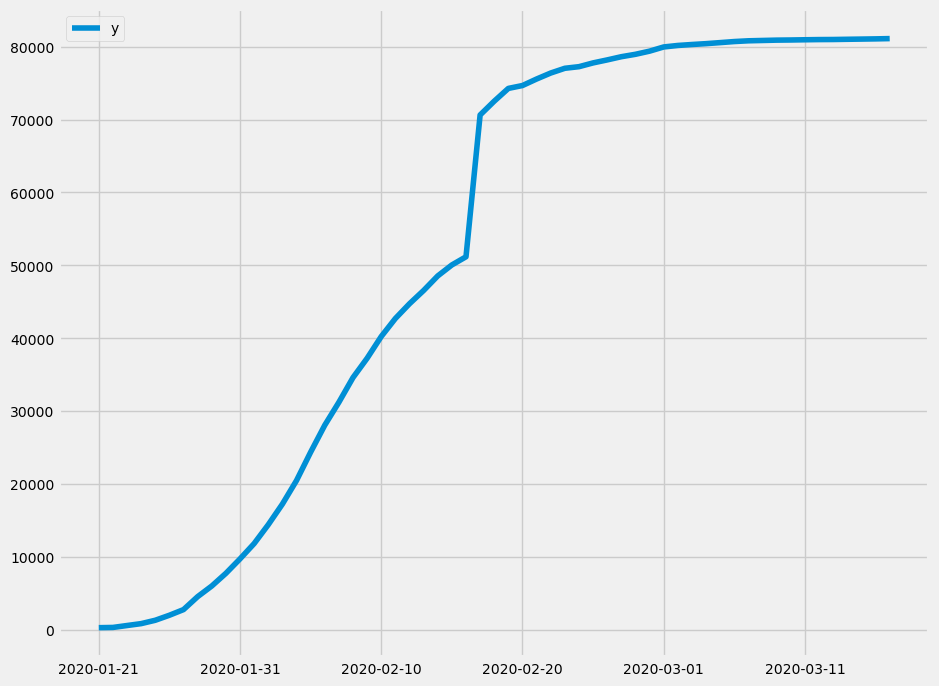

In [9]:
df = pd.read_csv(data + 'who-data/WHO_full_data2003.csv')
# Taking a subset of the data and renaming cols
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='');

11:38:27 - cmdstanpy - INFO - Chain [1] start processing
11:38:27 - cmdstanpy - INFO - Chain [1] done processing


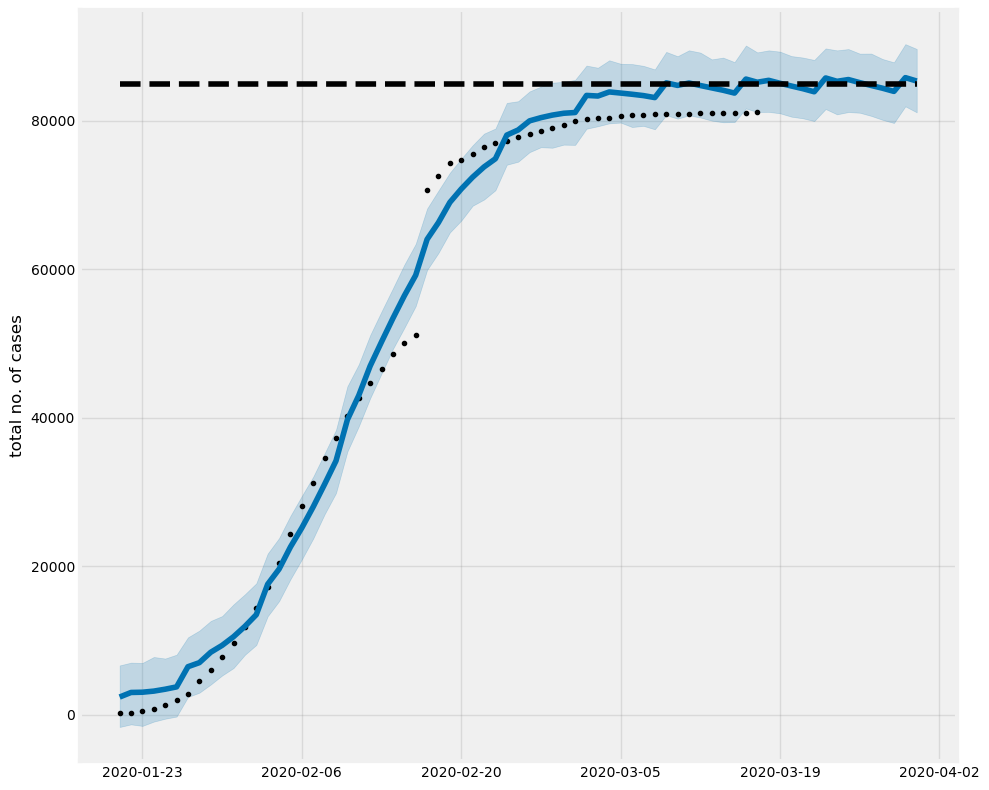

In [10]:
# Prophet can cap the forecast value as additional knowledge
df['cap'] = 85000

# Fit the model with growth parameter set to logistic.
m = Prophet(growth='logistic')
m.fit(df)
# Forecast
future = m.make_future_dataframe(periods=14)
future['cap'] = 85000
# Plot
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total no. of cases');

11:38:27 - cmdstanpy - INFO - Chain [1] start processing
11:38:27 - cmdstanpy - INFO - Chain [1] done processing


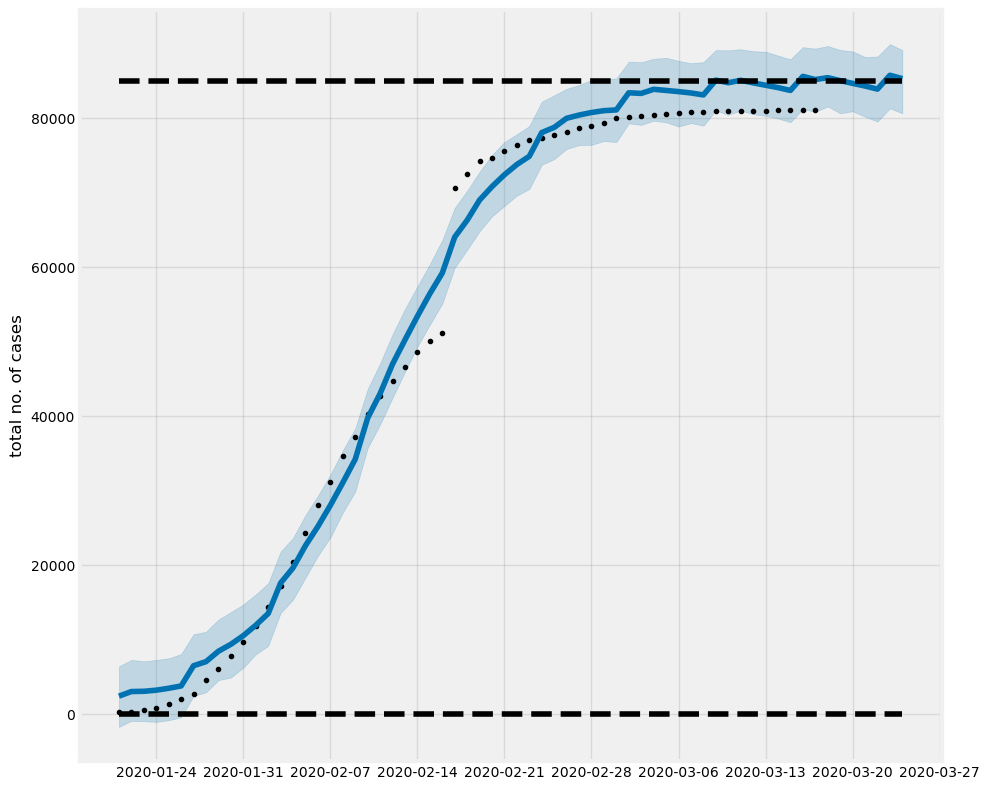

In [11]:
# The model can also incorporate about a floor as well as a cap
df['cap'] = 85000
df['floor'] = 0

# Fit the model
m = Prophet(growth='logistic')
m.fit(df)

# Predict
future = m.make_future_dataframe(periods=7)
future['cap'] = 85000
future['floor'] = 0
forecast = m.predict(future)
m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total no. of cases');


## Seasonality

Multiple seasonalities, which occur in parallel, are a relfection of the complexity of modeling time series data. This is another reason why simple Exponential Smoothing just doesn't cut it. Even approaches taken for relatively "advanced" ARIMA models to handle multiple seasonalities is clunky (adding dummies).

Addressing this challenge is where Prophet differentiates itself through the use of [Fourier](https://mathworld.wolfram.com/FourierSeries.html) expansion:

$$
S(t) = \sum_{i=1}^{N} \left( a_i \cos\left(\frac{2 \pi i t}{P} \right) + b_i \sin\left(\frac{2 \pi i t}{P} \right) \right)
$$

Functions can be combined, as in GAMs.

In [12]:
# Download additional datasets from Konrad's NB
dataset = "robikscube/hourly-energy-consumption"
download_path = "data/hourly-energy-consumption"

download_data(dataset, download_path)

Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
License(s): CC0-1.0


100%|█████████████████████████████████████| 11.4M/11.4M [00:04<00:00, 2.65MB/s]



Dataset 'robikscube/hourly-energy-consumption' has been downloaded to 'data/hourly-energy-consumption'


In [13]:
# Loading energy consumption data from PJM Interconnection LLC which is a regional transmission 
# organization in the US.
df = pd.read_csv(data + 'hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  178262 non-null  datetime64[ns]
 1   AEP       121273 non-null  float64       
 2   COMED     66497 non-null   float64       
 3   DAYTON    121275 non-null  float64       
 4   DEOK      57739 non-null   float64       
 5   DOM       116189 non-null  float64       
 6   DUQ       119068 non-null  float64       
 7   EKPC      45334 non-null   float64       
 8   FE        62874 non-null   float64       
 9   NI        58450 non-null   float64       
 10  PJME      145366 non-null  float64       
 11  PJMW      143206 non-null  float64       
 12  PJM_Load  32896 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 17.7 MB


In [14]:
df.describe().round(2)

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
count,178262,121273.00,66497.00,121275.00,57739.00,116189.00,119068.00,45334.00,62874.00,58450.00,145366.00,143206.00,32896.00
mean,2008-06-01 15:46:51.203734016,15499.51,11420.15,2037.85,3105.10,10949.20,1658.82,1464.22,7792.16,11701.68,32080.22,5602.38,29766.43
min,1998-04-01 01:00:00,9581.00,7237.00,982.00,907.00,1253.00,1014.00,514.00,0.00,7003.00,14544.00,487.00,17461.00
25%,2003-05-02 09:15:00,13630.00,9780.00,1749.00,2687.00,9322.00,1444.00,1185.00,6807.00,9954.00,27573.00,4907.00,25473.00
50%,2008-06-01 16:30:00,15310.00,11152.00,2009.00,3013.00,10501.00,1630.00,1386.00,7700.00,11521.00,31421.00,5530.00,29655.00
75%,2013-07-03 00:45:00,17200.00,12510.00,2279.00,3449.00,12378.00,1819.00,1699.00,8556.00,12896.75,35650.00,6252.00,33073.25
max,2018-08-03 00:00:00,25695.00,23753.00,3746.00,5445.00,21651.00,3054.00,3490.00,14032.00,23631.00,62009.00,9594.00,54030.00
std,NaN,2591.40,2304.14,393.40,599.86,2413.95,301.74,378.87,1331.27,2371.50,6464.01,979.14,5849.77


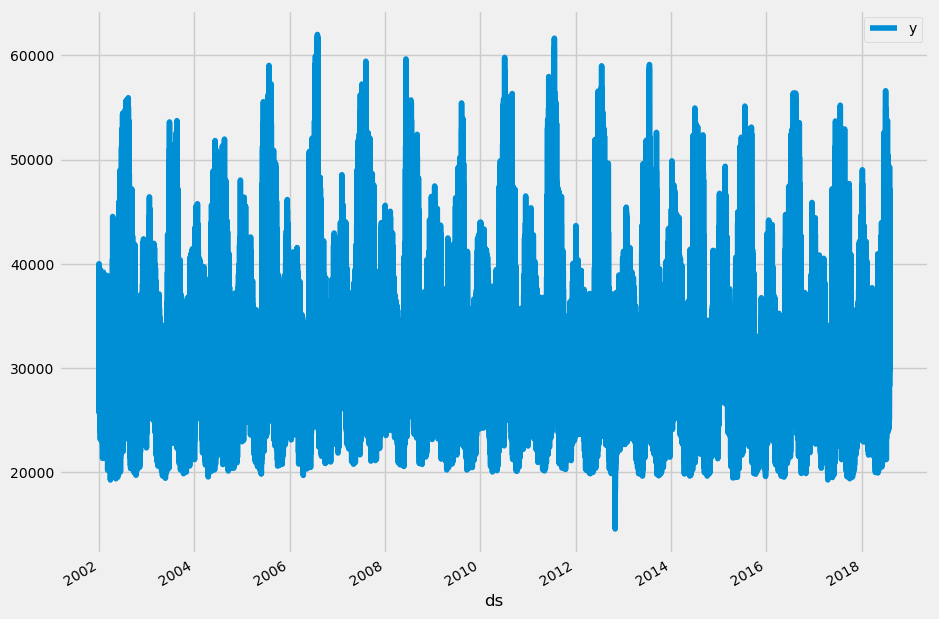

In [15]:
# Since Prophet is built for univariate data, we can pick a series.
# To demo additional out-of-the-box functionality, we will progressively aggregate
# to lower frequencies.

# Using Hourly
xdat = df[['Datetime', 'PJME']]
# Trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={'Datetime': 'ds', 'PJME': 'y'})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2));

11:38:36 - cmdstanpy - INFO - Chain [1] start processing
11:38:55 - cmdstanpy - INFO - Chain [1] done processing


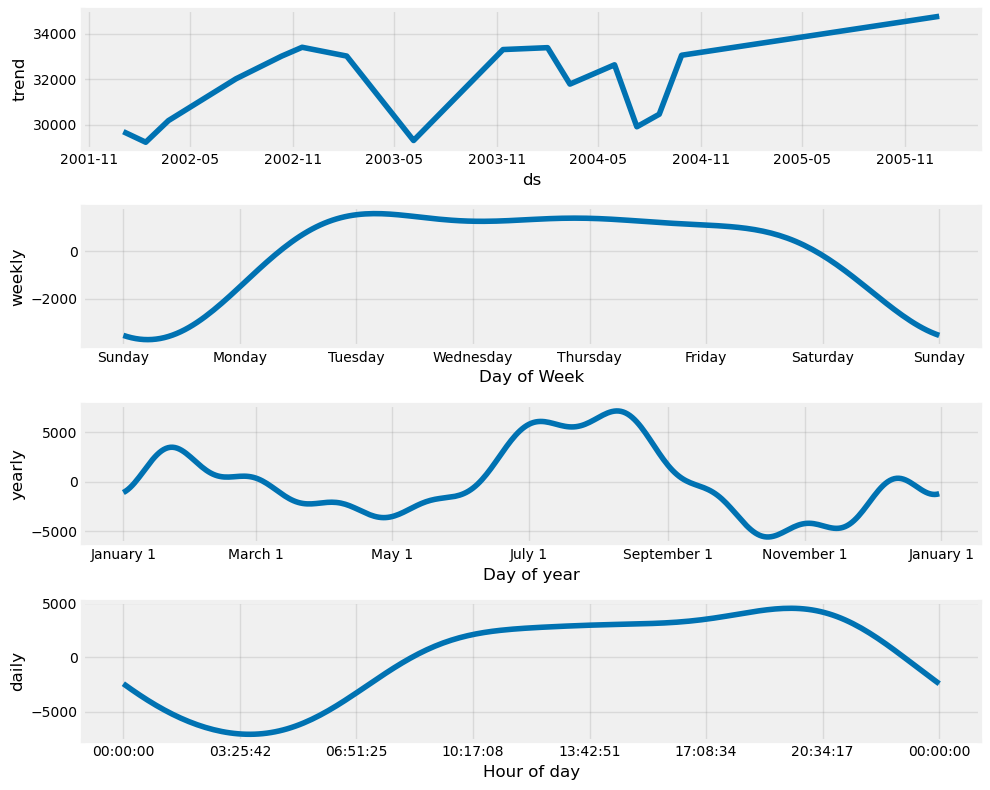

In [16]:
# Reducing the dataset for speed while keeping in mind that we will
# need to retain at least two complete cycles for each seasonality we want to model
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

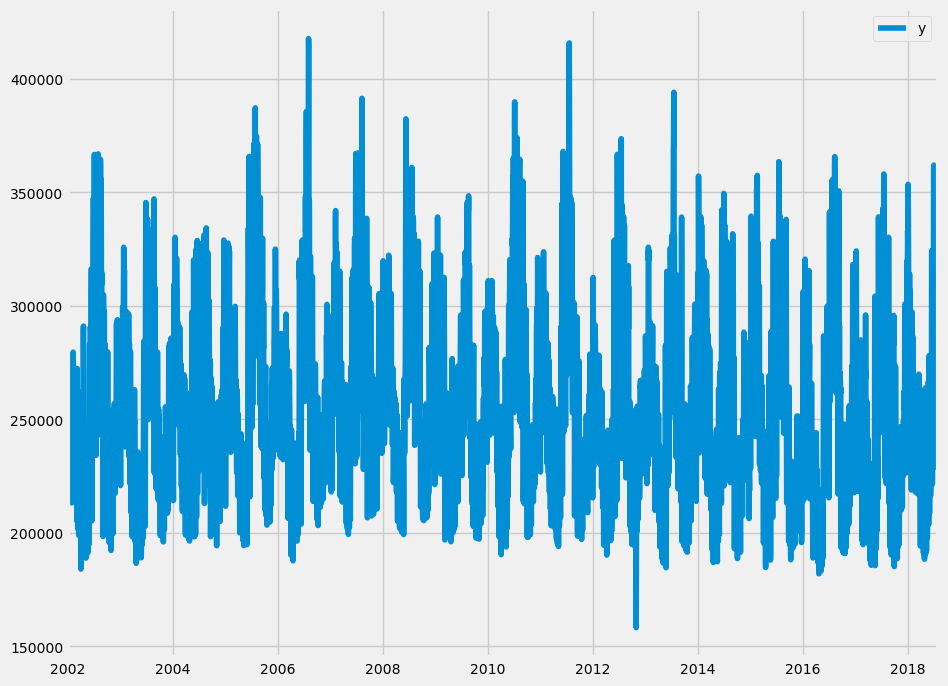

In [17]:
# Lets aggregate to daily frequency
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={'Datetime': 'ds', 'PJME': 'y'})
xdat['y'] /= 10^9
# Purging the leading zeros along with the last observation - There are only a few hours of the last day in the sample
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '');

11:38:59 - cmdstanpy - INFO - Chain [1] start processing
11:38:59 - cmdstanpy - INFO - Chain [1] done processing


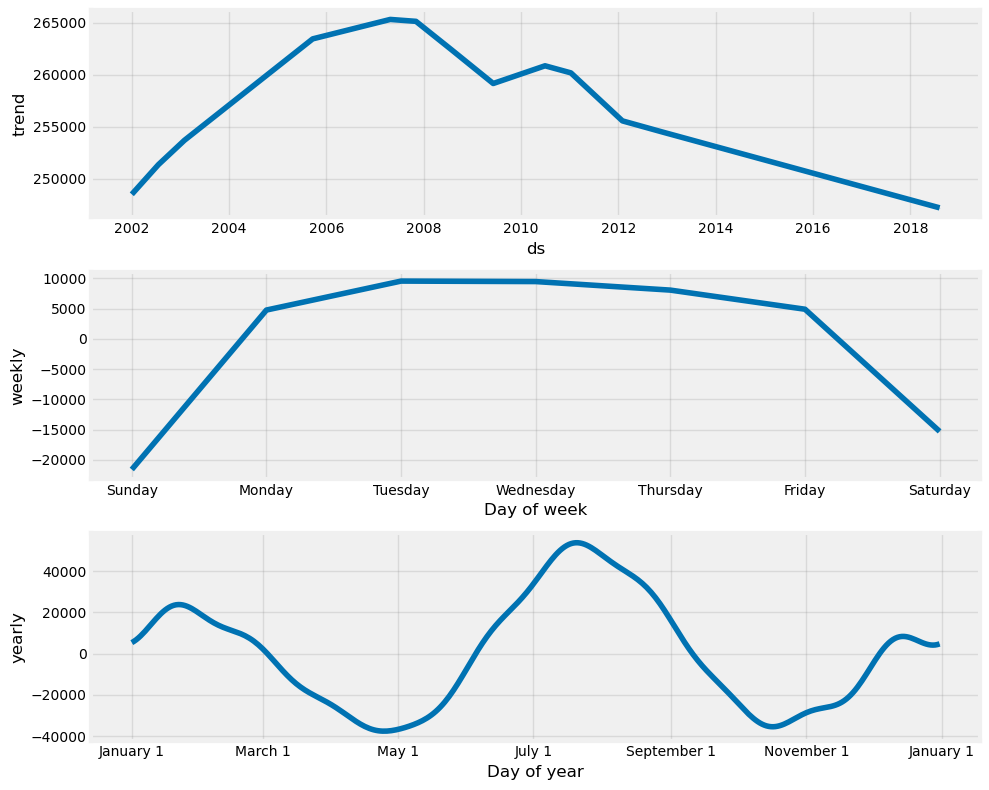

In [18]:
# Modeling over daily data
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

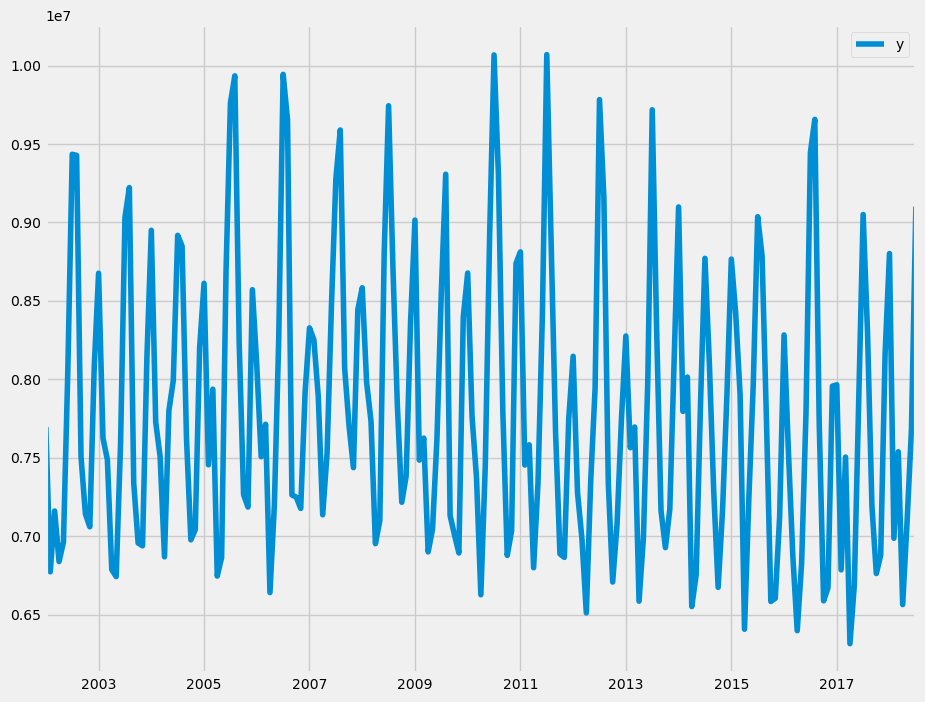

In [19]:
# Downsampling to monthly
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# Same as beofre
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '');

11:39:00 - cmdstanpy - INFO - Chain [1] start processing
11:39:00 - cmdstanpy - INFO - Chain [1] done processing


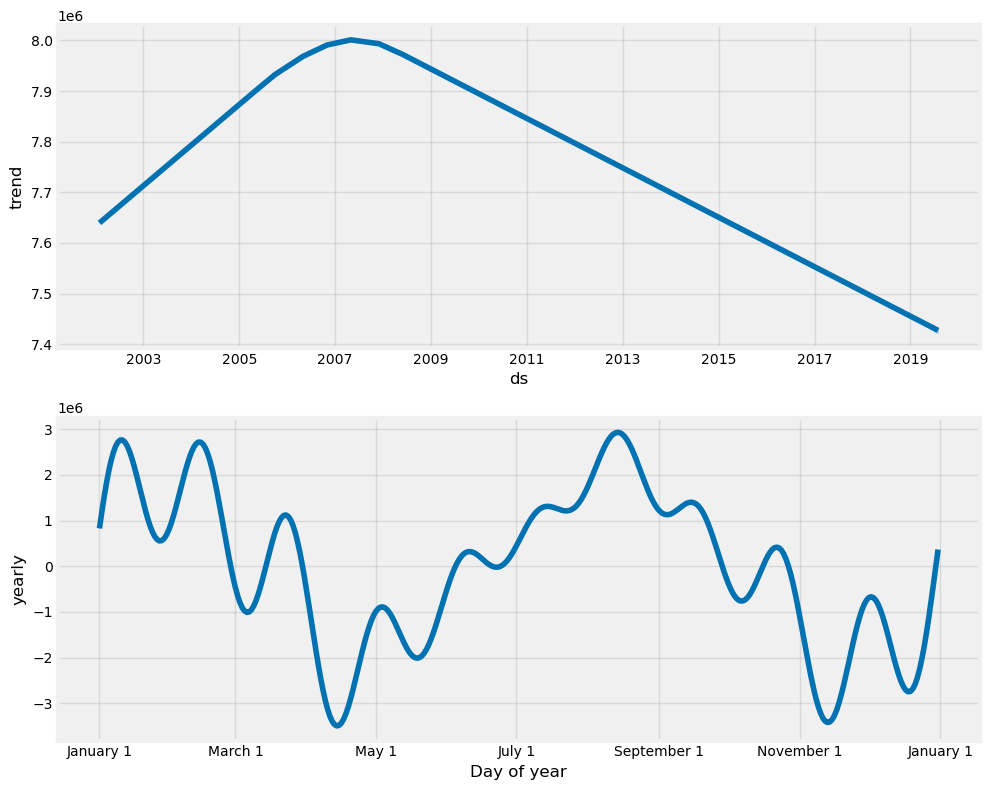

In [20]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

### Seasonality Specification

Additional modelling options include setting the seasonality mode i.e. either additive or multiplicative.

11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing


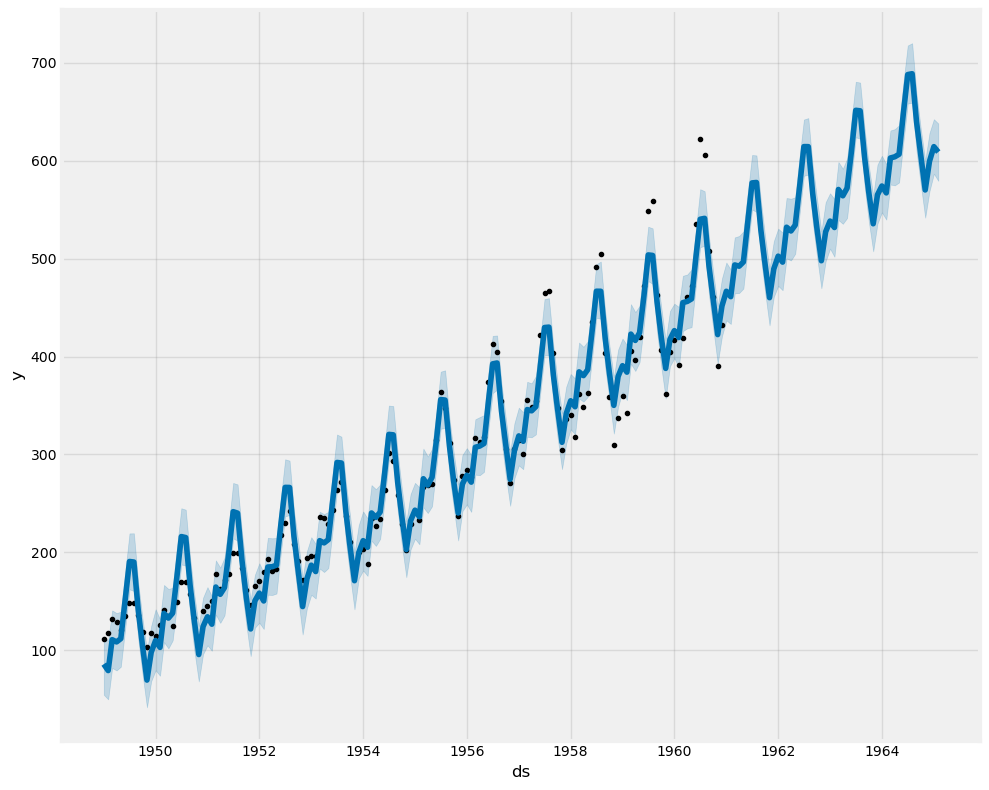

In [22]:
# First, using the air passengers dataset, we can see additive seasonality in action
df = pd.read_csv(data + 'example_air_passengers.csv')

m = Prophet(seasonality_mode='additive')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show();

11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing


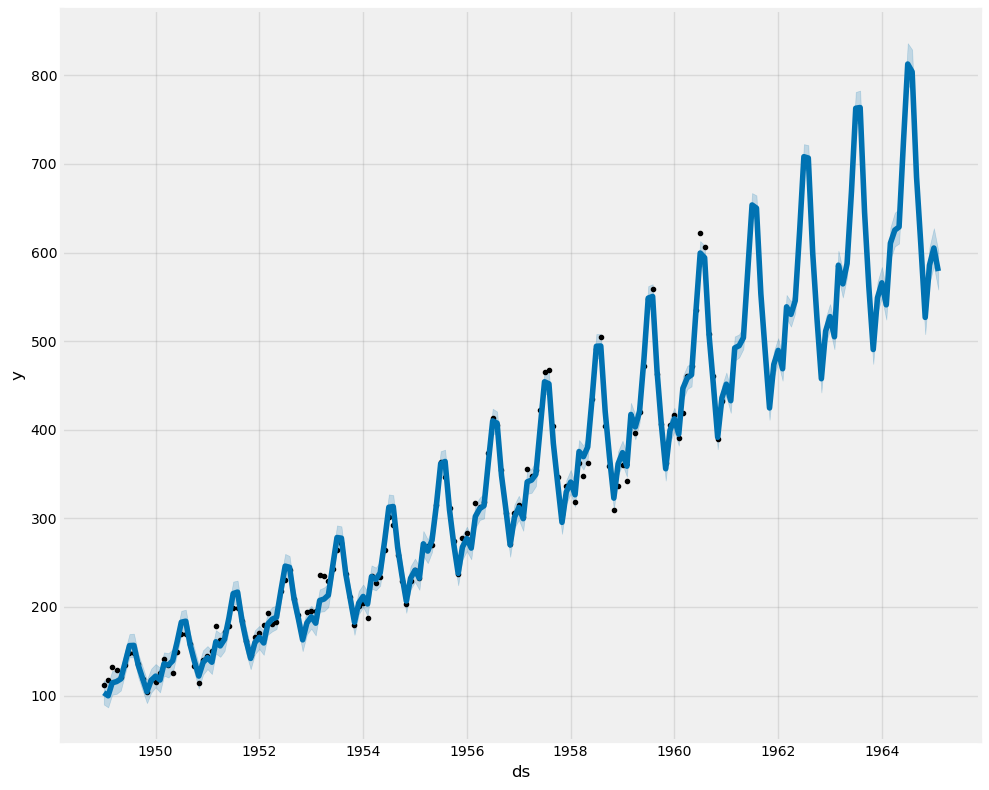

In [23]:
# Multiplicative modelling is the alternative method
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show();

In case there are strong seasonal components being observed, we can opt to leave them in - as in the plot above - or have them reduced. `seasonality_prior_scale` allows us to factor in how much the model will fit the seasonality in the data.

In [48]:
def f_cast(model, df):
    model.fit(df)
    future = model.make_future_dataframe(50, freq='MS')
    forecast = model.predict(future)
    fig = model.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
    plt.show();
    return forecast

In [49]:
m1 = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale = 1.5)
m2 = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale = 10)

12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


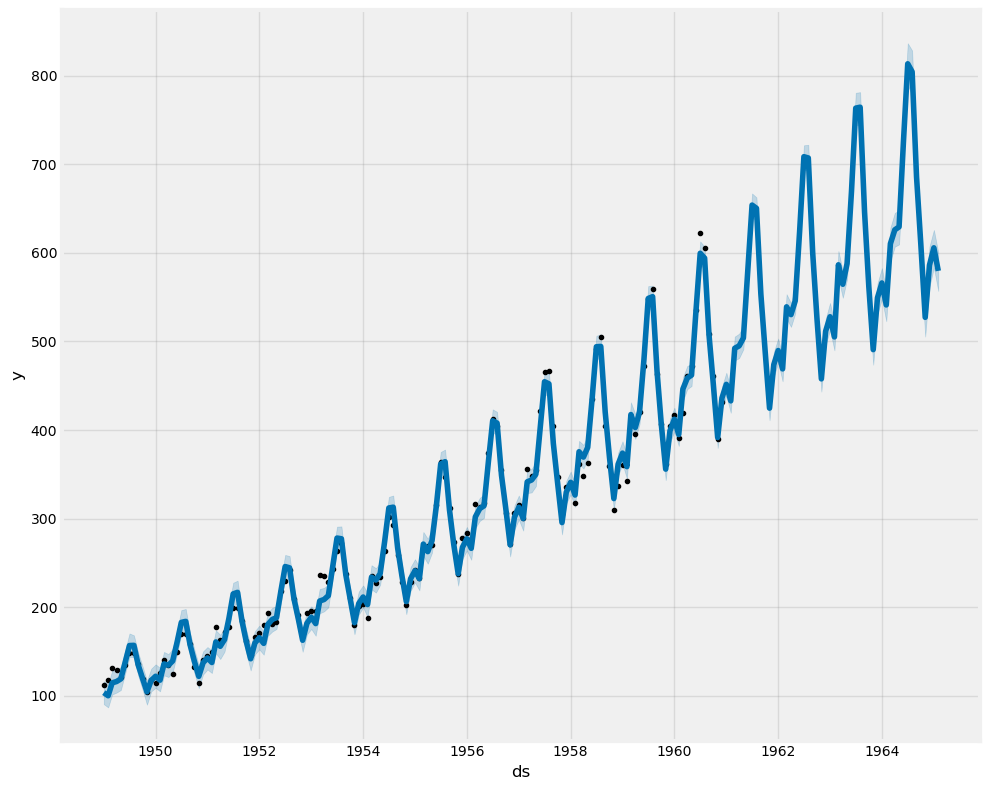

In [50]:
fcast1 = f_cast(m1, df)

12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:54 - cmdstanpy - INFO - Chain [1] done processing


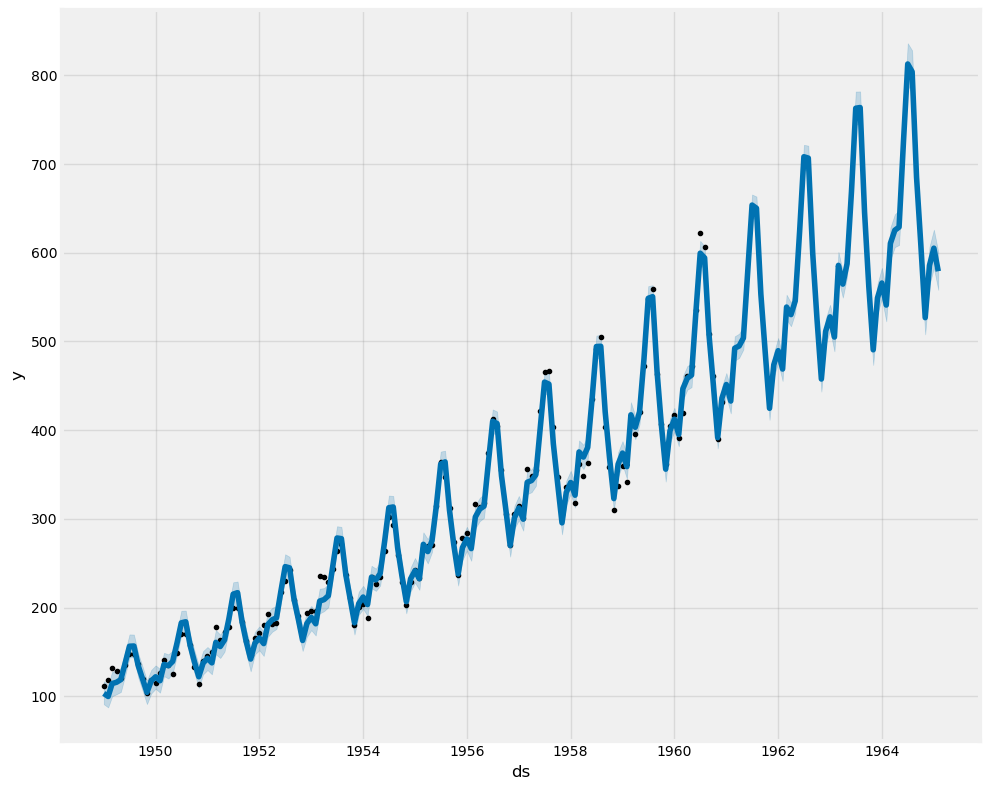

In [51]:
fcast2 = f_cast(m2, df)

In [52]:
fcast1  # Using 1.5 for the seasonality_prior scale

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,113.857100,90.666385,116.480236,113.857100,113.857100,-0.089829,-0.089829,-0.089829,-0.089829,-0.089829,-0.089829,0.0,0.0,0.0,103.629436
1,1949-02-01,115.592502,87.017543,113.750636,115.592502,115.592502,-0.133645,-0.133645,-0.133645,-0.133645,-0.133645,-0.133645,0.0,0.0,0.0,100.144183
2,1949-03-01,117.159962,101.565279,128.212424,117.159962,117.159962,-0.021186,-0.021186,-0.021186,-0.021186,-0.021186,-0.021186,0.0,0.0,0.0,114.677762
3,1949-04-01,118.895364,103.722570,130.038057,118.895364,118.895364,-0.022866,-0.022866,-0.022866,-0.022866,-0.022866,-0.022866,0.0,0.0,0.0,116.176702
4,1949-05-01,120.574786,106.598155,132.450158,120.574786,120.574786,-0.012002,-0.012002,-0.012002,-0.012002,-0.012002,-0.012002,0.0,0.0,0.0,119.127706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1964-10-01,654.773842,587.966812,628.925711,636.549370,670.850170,-0.068350,-0.068350,-0.068350,-0.068350,-0.068350,-0.068350,0.0,0.0,0.0,610.019723
190,1964-11-01,658.366614,505.506778,546.824825,639.613155,675.189441,-0.199237,-0.199237,-0.199237,-0.199237,-0.199237,-0.199237,0.0,0.0,0.0,527.195492
191,1964-12-01,661.843490,561.800006,607.006143,642.535899,679.318424,-0.114566,-0.114566,-0.114566,-0.114566,-0.114566,-0.114566,0.0,0.0,0.0,586.018643
192,1965-01-01,665.436261,583.204468,625.852855,645.324308,683.255226,-0.089829,-0.089829,-0.089829,-0.089829,-0.089829,-0.089829,0.0,0.0,0.0,605.660819


In [53]:
fcast2 # Using 10, which is the default value for comparison

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,113.457154,91.034009,116.863733,113.457154,113.457154,-0.090209,-0.090209,-0.090209,-0.090209,-0.090209,-0.090209,0.0,0.0,0.0,103.222279
1,1949-02-01,115.212069,87.474105,113.234501,115.212069,115.212069,-0.133979,-0.133979,-0.133979,-0.133979,-0.133979,-0.133979,0.0,0.0,0.0,99.776094
2,1949-03-01,116.797153,99.978404,127.556545,116.797153,116.797153,-0.021072,-0.021072,-0.021072,-0.021072,-0.021072,-0.021072,0.0,0.0,0.0,114.336052
3,1949-04-01,118.552067,102.300605,129.047495,118.552067,118.552067,-0.023166,-0.023166,-0.023166,-0.023166,-0.023166,-0.023166,0.0,0.0,0.0,115.805724
4,1949-05-01,120.250372,104.826350,131.754370,120.250372,120.250372,-0.012221,-0.012221,-0.012221,-0.012221,-0.012221,-0.012221,0.0,0.0,0.0,118.780781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1964-10-01,654.471733,588.536166,629.841574,637.667474,671.040311,-0.068661,-0.068661,-0.068661,-0.068661,-0.068661,-0.068661,0.0,0.0,0.0,609.535095
190,1964-11-01,658.056578,507.954072,546.497534,640.581603,675.138232,-0.199448,-0.199448,-0.199448,-0.199448,-0.199448,-0.199448,0.0,0.0,0.0,526.808371
191,1964-12-01,661.525783,563.650252,606.509238,643.327685,679.074675,-0.114700,-0.114700,-0.114700,-0.114700,-0.114700,-0.114700,0.0,0.0,0.0,585.648481
192,1965-01-01,665.110628,582.786788,626.013525,646.330684,683.325186,-0.090209,-0.090209,-0.090209,-0.090209,-0.090209,-0.090209,0.0,0.0,0.0,605.111556


In [61]:
# Assessing relative impact using abs % differences
cols = ['trend', 'multiplicative_terms', 'yearly', 'yhat']
diff = ((fcast1[cols] - fcast2[cols]) / ((fcast1[cols] + fcast2[cols])/2))*100
diff

,trend,multiplicative_terms,yearly,yhat
0,0.351888,-0.422365,-0.422365,0.393670
1,0.329659,-0.249721,-0.249721,0.368236
2,0.310150,0.543543,0.543543,0.298418
3,0.289156,-1.302166,-1.302166,0.319833
4,0.269419,-1.812999,-1.812999,0.291646
...,...,...,...,...
189,0.046150,-0.453146,-0.453146,0.079476
190,0.047103,-0.105853,-0.105853,0.073457
191,0.048015,-0.117170,-0.117170,0.063185
192,0.048947,-0.422365,-0.422365,0.090729


In [60]:
diff.describe().round(3)

,trend,multiplicative_terms,yearly,yhat
count,194.000,194.000,194.000,194.000
mean,-0.005,-1.195,-1.195,0.016
std,0.098,6.439,6.439,0.102
min,-0.200,-44.766,-44.766,-0.194
25%,-0.060,-0.250,-0.250,-0.047
50%,-0.006,-0.052,-0.052,0.017
75%,0.037,0.138,0.138,0.062
max,0.352,2.253,2.253,0.394


#### Interval Forecasts

Interval forecasts allow point estimates to be combined with uncertainty. The default for the `mcmc_samples` is 0 and to get intervals around seasonality, full Bayesian sampling is needed. Uncertainty around the trend is calculated with Maximum A Posteriori (MAP).

**Now, there is a lot of discussion these days around uncertainty quantification and the role of Bayesian approaches versus Conformal Prediction. The views are really strong on both sides. Being a responsible data professional means assessing the merits and tradeoffs with both schools of thought, while setting up carefully structured deep dives.**

In [121]:
## Moving back to the energy dataset
df = pd.read_csv('data/hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})

In [140]:
# Update forecasting function
def forecast(m, df, p, f):
    m = m.fit(df)
    future = m.make_future_dataframe(periods=p, freq=f)
    forecast = m.predict(future)
    m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

14:43:32 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing


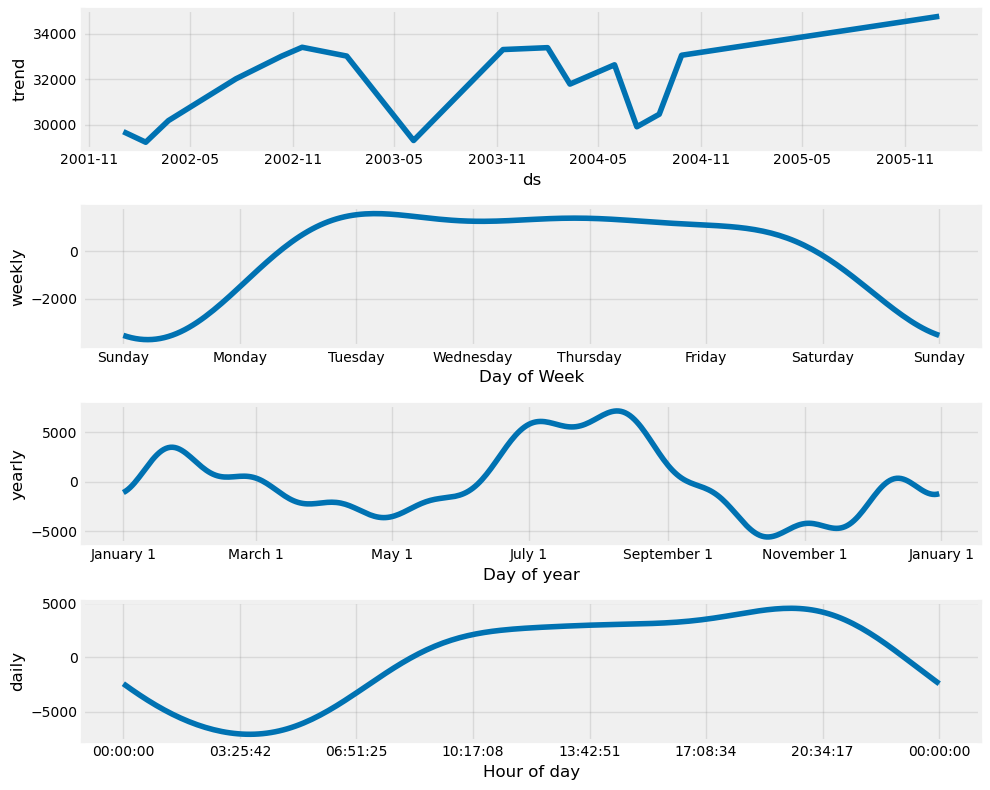

In [130]:
# Recreating the trend and seasonality model
forecast(Prophet(), xdat.iloc[:30000], 24, 'H')

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

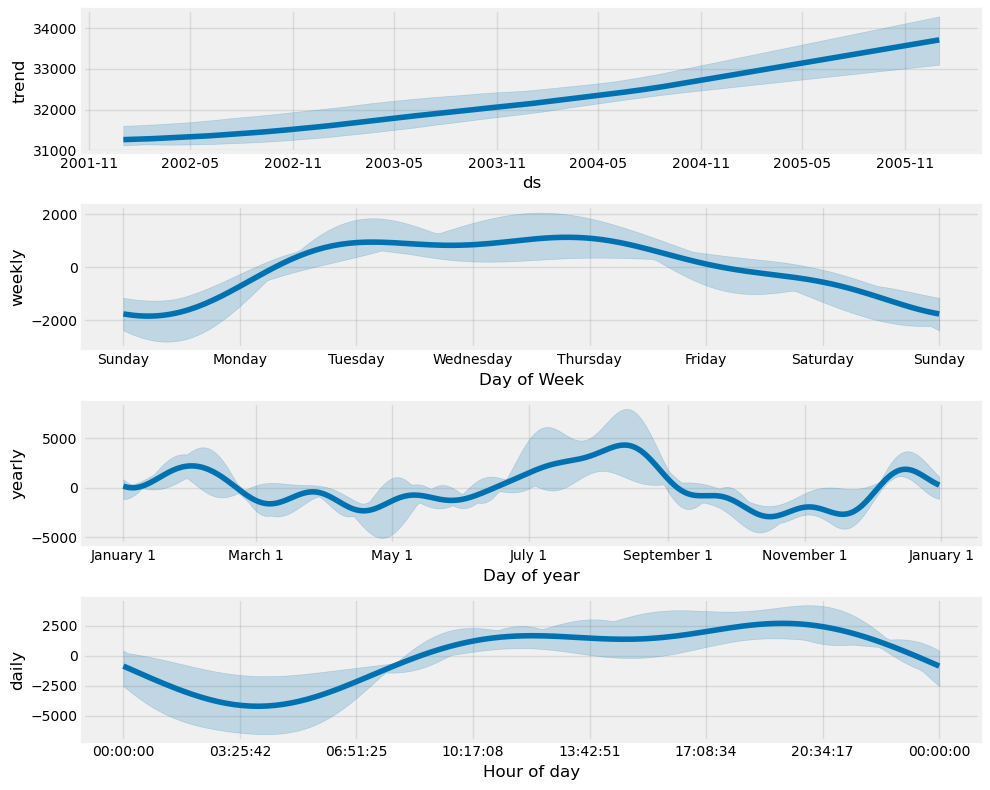

In [144]:
import logging
# Disabling a verbose sampling warning error
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Switching to Bayesian inference and using positive integers
forecast(Prophet(mcmc_samples=10),  xdat.iloc[:30000], 24, 'H')

## Handling Special Days

Special days / events, such as holidays, geo-political or world events - such as wars or major sporting events - etc., can have measurable impacts on forecasting performance. They need to be handling separately from trends and seasonality.

### Holidays

In [145]:
# Download additional datasets from Konrad's NB
dataset = "konradb/norway-bicycles"
download_path = "data/norway-bicycles"

download_data(dataset, download_path)

Dataset URL: https://www.kaggle.com/datasets/konradb/norway-bicycles
License(s): unknown

Dataset 'konradb/norway-bicycles' has been downloaded to 'data/norway-bicycles'


100%|█████████████████████████████████████| 12.4k/12.4k [00:00<00:00, 5.24MB/s]


In [146]:
# Loading Bike ride data
bikerides = pd.read_csv('data/norway-bicycles/bikerides_day.csv', encoding='unicode_escape', delimiter=',')
bikerides.head()

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8


In [147]:
bikerides.describe()

,Volume,Rain,Temp
count,1273.000000,1273.000000,1273.000000
mean,2609.344855,1.945640,6.783975
std,1968.623825,4.505151,7.726084
min,63.000000,0.000000,-11.400000
25%,1185.000000,0.000000,0.700000
50%,2073.000000,0.000000,5.500000
75%,3801.000000,1.400000,13.400000
max,8679.000000,39.500000,25.900000


In [149]:
# Reformatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

In [153]:
# Lets see which Norwegian holidays are listed in the model
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List names
m.train_holiday_names

0              New Year's Day
1             Maundy Thursday
2                 Good Friday
3               Easter Sunday
4               Easter Monday
5                   Labor Day
6            Constitution Day
7               Ascension Day
8                 Whit Sunday
9                 Whit Monday
10              Christmas Day
11    Second Day of Christmas
dtype: object

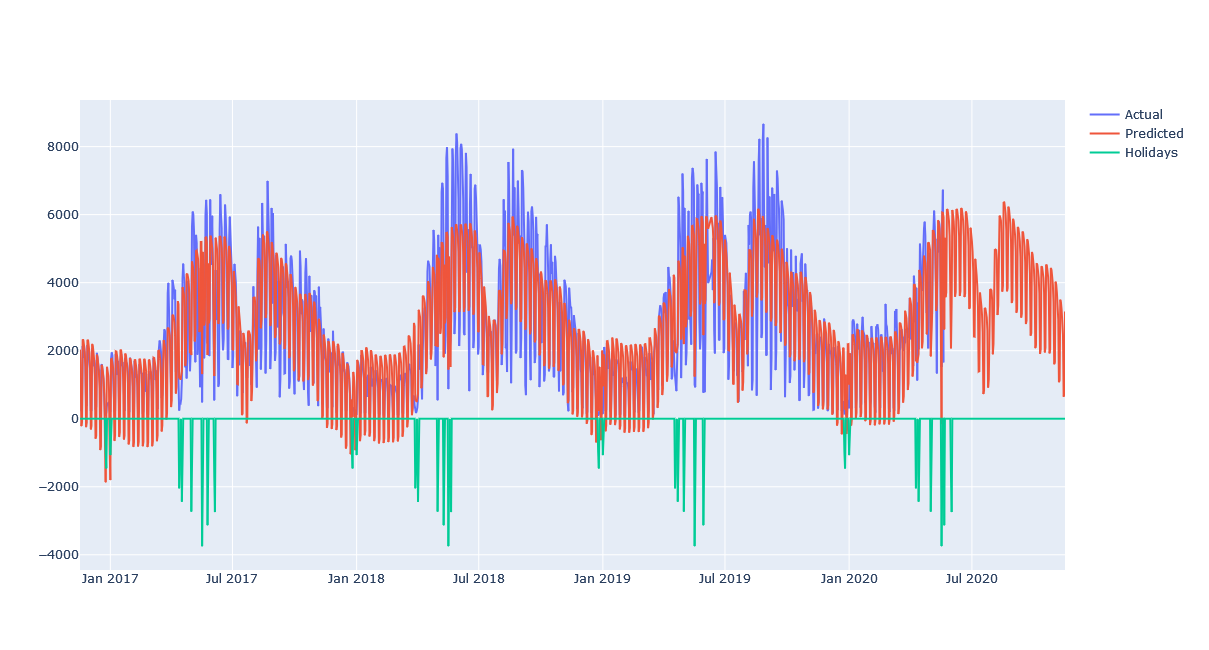

In [158]:
# Creating future dataframe
future = m.make_future_dataframe(periods=180, freq='D')
forecast = m.predict(future)

# Moving over to plotly for easier overlays
fig = go.Figure(layout={'height': 650})
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual')) # Bike Ride layer
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted')) # Forecast Layer
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays')) # Holidays
fig.show()

There seems to be an issue with the predictions during Christmas, so the data points need augmentation before passing to the model. According to Konrad's NB:

> `ds` - so we know when the holiday of interest occurs.
> 
> `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below lower_window equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas upper_window is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week.


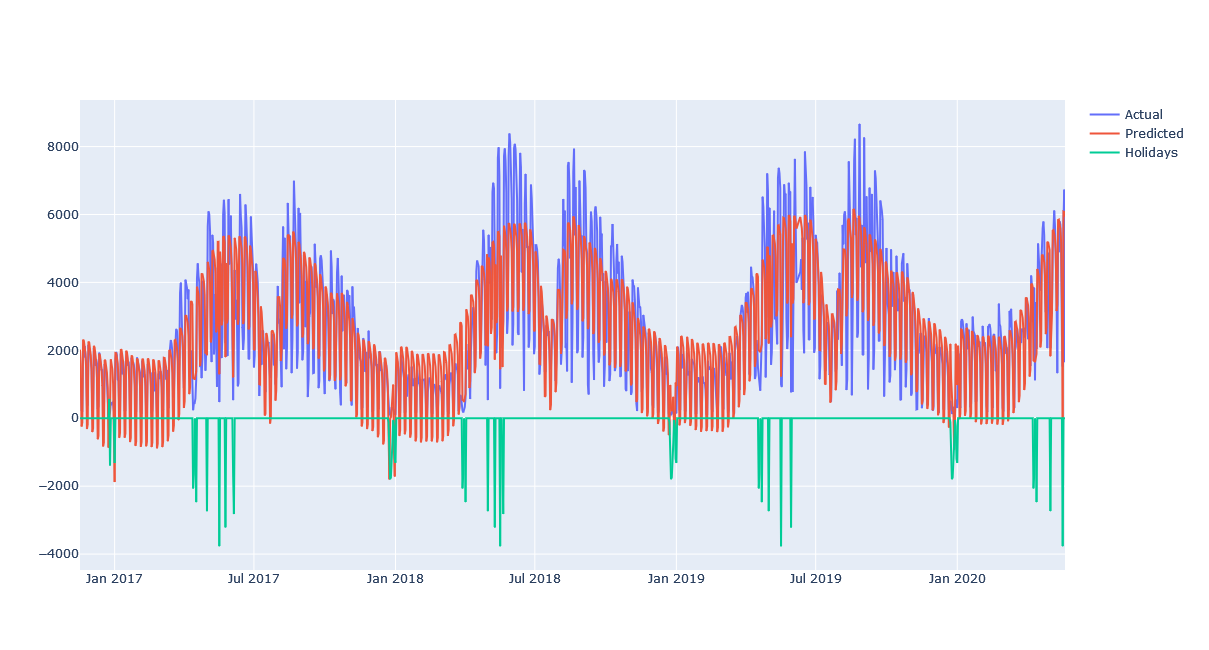

In [160]:
christmas = pd.DataFrame({
    'holiday' : 'Christmas',
    'ds' : pd.to_datetime(['2017-12-24', '2018-12-24', '2019-12-24', '2020-12-24']),
    'lower_window': -1,
    'upper_window': 7
})

m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure(layout={'height': 650})
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()